## Fit & Validate A Gradient Boosted Classifier and Generate Related Visualizations

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc, roc_curve

/home/eric/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("../data/df_mvp.csv")

In [3]:
# Split the response variable from the predictors
X = df.drop(['label','time_bin','source'],axis=1)
y = df.label

# Split the training from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Within the training data, define validation sets:
X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Put the training data in a format more suited to XGBoost
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

In [4]:
# Initialize and train our classifier
# specify parameters via dict
params = {'max_depth':2, 
         'eta':1, 
         'objective':'binary:logistic',
         'nthread':4,
         'eval_metric':'auc',
         'num_round':100}

# Fit our classifier
clf = xgb.XGBClassifier(**params)

clf.fit(X_train, y_train, 
        eval_set=[(X_val_train, y_val_train), (X_val, y_val)],
        eval_metric='logloss',
        verbose = False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, num_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False, ...)

In [5]:
# make prediction
y_score = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,-1]

accuracy = accuracy_score(y_test, y_score)
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
false_pos, true_pos, _ = roc_curve(y_test, y_pred_proba, pos_label=1.0)
area_under_curve = auc(false_pos,true_pos)

f = open("../src/d05_reporting/modeling_metrics_xgb", 'w')
f.write("accuracy: "+str(np.round(accuracy,3))+"\n")
f.write("precision: "+str(np.round(precision,3))+"\n")
f.write("recall: "+str(np.round(recall,3))+"\n")
f.write("ROC AUC: "+str(np.round(area_under_curve,3)))
f.close()

In [6]:
# Plot ROC curve
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.plot(false_pos, true_pos, color='darkorange',
label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosted Classifier')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../src/d06_visuals/modeling_xgb_ROC.png")
#plt.show()

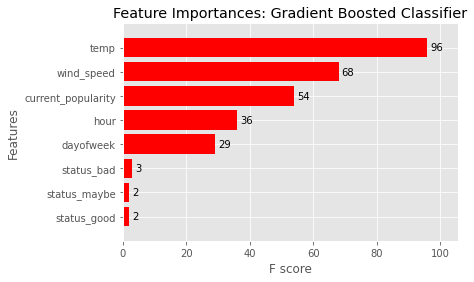

In [7]:
# Plot feature importance
from xgboost import plot_importance
plot_importance(clf,height=0.8, color = 'red')
plt.title("Feature Importances: Gradient Boosted Classifier")
plt.savefig("../src/d06_visuals/modeling_xgb_feature_importances.png", bbox_inches = 'tight')
#plt.show()